In [1]:
%load_ext autoreload
%autoreload 2

### Graph embedding notebook

Evaluate options for graph embeddings

some useful references:

- https://distill.pub/2021/gnn-intro/
- https://web.stanford.edu/class/cs224w/
- https://pytorch-geometric.readthedocs.io/en/latest/

Structure of the nb:

1) data prep
2) model and training
3) visualization

Next steps:

Train/test split, include Argoverse data

In [2]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
import networkx as nx
import numpy as np
from enum import Enum

import pickle
import networkx as nx
from torch_geometric.nn import GINEConv, global_mean_pool, global_max_pool, global_add_pool

import torch
import torch.nn.functional as F
import os
import glob
import pickle
import numpy as np
from sklearn.model_selection import train_test_split

import torch
import torch.nn.functional as F
from torch_geometric.data import DataLoader
import glob
import pickle
from tqdm import tqdm
from graph_creator.plot_graphs import plot_lane_map_advanced, add_actors_to_map, add_actor_edges_to_map
from graph_creator.MapGraph import MapGraph
import seaborn as sns
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd

from graph_creator.graph_embeddings import GraphDataset, TrainableGraphGINE, contrastive_loss, augment_graph, get_feature_dimensions, networkx_to_pyg

### Data prep

In [3]:
graph_paths = glob.glob("/home/tmuehlen/repos/graph_coverage/actor_graphs/carla_w_intersection/*.pkl")
# graph_paths = glob.glob("/home/tmuehlen/repos/graph_coverage/actor_graphs/carla/*.pkl")
# graph_paths = [path for path in graph_paths if "2025-09-05" in path]
print(len(graph_paths))


6667


In [4]:
# open one graph
with open(graph_paths[0], 'rb') as f:
    graph = pickle.load(f)
#graph.graph.graph
print(graph.nodes(data=True)["583"])
graph.edges(data=True)


{'lane_id': '1_1', 'lane_ids': ['1_1'], 's': 33.50000810623169, 'xyz': <POINT Z (-77.501 2.738 0.021)>, 'lon_speed': 6.361424280807165, 'actor_type': <ActorType.VEHICLE: 'VEHICLE'>, 'lane_change': False, 'is_on_intersection': False}


OutMultiEdgeDataView([('583', '568', {'edge_type': 'following_lead', 'path_length': 43.75999861955643}), ('568', '583', {'edge_type': 'following_lead', 'path_length': 43.75999861955643})])

In [7]:
# add argoverse data
# currently not yet having is_on_intersection, hence not using for the moment
argoverse_graph_paths = glob.glob("/home/tmuehlen/repos/graph_coverage/actor_graphs/argoverse_nx/*.pkl")
graph_paths.extend(argoverse_graph_paths)
print(len(graph_paths))

# open one argoverse graph

with open(argoverse_graph_paths[0], 'rb') as f:
    graph = pickle.load(f)
#graph.graph.graph
print(graph.nodes(data=True))
graph.edges(data=True)

18019
[('73423', {'lane_id': '390751807', 'lane_ids': ['390751807', '390752162', '390802935'], 's': 22.829008547463282, 'xyz': <POINT Z (-321.999 -1049.842 0)>, 'lon_speed': 10.481008913566132, 'actor_type': <ActorType.VEHICLE: 'VEHICLE'>, 'lane_change': False, 'is_on_intersection': True}), ('73659', {'lane_id': '390755349', 'lane_ids': ['390755349'], 's': 23.73894567937526, 'xyz': <POINT Z (-282.585 -922.653 0)>, 'lon_speed': 8.850980925174806, 'actor_type': <ActorType.VEHICLE: 'VEHICLE'>, 'lane_change': False, 'is_on_intersection': False}), ('73695', {'lane_id': '390801189', 'lane_ids': ['390801189', '390801632'], 's': 13.750467191524383, 'xyz': <POINT Z (-273.089 -948.26 0)>, 'lon_speed': 1.6580297826963417, 'actor_type': <ActorType.VEHICLE: 'VEHICLE'>, 'lane_change': True, 'is_on_intersection': True}), ('73858', {'lane_id': '390751815', 'lane_ids': ['390751815'], 's': 19.93550774022581, 'xyz': <POINT Z (-330.512 -1075.1 0)>, 'lon_speed': 10.099711942216002, 'actor_type': <ActorType

OutMultiEdgeDataView([('73423', '73858', {'edge_type': 'following_lead', 'path_length': 26.645672972951026}), ('73423', '73890', {'edge_type': 'opposite_vehicle', 'path_length': 60.819369052660036}), ('73423', '73943', {'edge_type': 'opposite_vehicle', 'path_length': 76.13831339285397}), ('73659', 'AV', {'edge_type': 'neighbor_vehicle', 'path_length': 47.595230559350895}), ('73659', '73943', {'edge_type': 'opposite_vehicle', 'path_length': 61.37801644839739}), ('73695', '73871', {'edge_type': 'following_lead', 'path_length': 20.325583413171504}), ('73858', '73423', {'edge_type': 'following_lead', 'path_length': 26.645672972951026}), ('73871', '73956', {'edge_type': 'following_lead', 'path_length': 16.444342035765224}), ('73871', '73695', {'edge_type': 'following_lead', 'path_length': 20.325583413171504}), ('73876', '73935', {'edge_type': 'following_lead', 'path_length': 17.22417714430063}), ('73890', '73423', {'edge_type': 'opposite_vehicle', 'path_length': 60.819369052660036}), ('7393

In [ ]:
# Load data
graph_ds = GraphDataset(graph_paths)
train_loader = DataLoader(graph_ds, batch_size=128, shuffle=True)

/home/tmuehlen/.cache/pypoetry/virtualenvs/graph-creator-_1ofKhL9-py3.10/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
# set([path.split("/")[-1].split("_")[1] for path in graph_paths])

In [9]:
# try out data loader
graph_ds.__getitem__(4320)

#batch = next(iter(train_loader))

(Data(x=[6, 7], edge_index=[2, 10], edge_attr=[10, 7]),
 '/home/tmuehlen/repos/graph_coverage/actor_graphs/carla_w_intersection/graph_2025-10-05 21:42:38.462000_Town02_12_0.pkl')

### Training

In [10]:
# Model setup
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = "cpu"
node_dim, edge_dim = get_feature_dimensions()
model = TrainableGraphGINE(node_dim, edge_dim, 256, 96, 4).to(device)



In [ ]:
node_dim

In [11]:
# get the pre-training loss
total_loss = 0

with torch.no_grad():
    for batch in train_loader:
        batch = batch[0].to(device)
        aug_batch = augment_graph(batch).to(device)
        outputs1 = model(batch)
        outputs2 = model(aug_batch)
        loss = contrastive_loss(outputs1['projection'], outputs2['projection'])
        total_loss += loss.item()

# if epoch % 1 == 0:
print(f'pre-training loss:: {total_loss/len(train_loader):.4f}')

pre-training loss:: 2.3071


In [12]:
# Training
# hm, too lazy to do a proper learning rate schedule
for i in range(2):
    lr = 0.02*0.75**i
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    print(f"loop {i}, Learning rate: {lr}")
    for epoch in range(15):
        total_loss = 0
    
        for batch in train_loader:
            batch = batch[0].to(device)
            aug_batch = augment_graph(batch).to(device)

            optimizer.zero_grad()

            outputs1 = model(batch)
            outputs2 = model(aug_batch)

            loss = contrastive_loss(outputs1['projection'], outputs2['projection'])
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # if epoch % 1 == 0:
        print(f'Epoch {epoch}, Loss: {total_loss/len(train_loader):.4f}')



loop 0, Learning rate: 0.02
Epoch 0, Loss: 0.8176
Epoch 1, Loss: 0.4135
Epoch 2, Loss: 0.3056
Epoch 3, Loss: 0.2662
Epoch 4, Loss: 0.2369
Epoch 5, Loss: 0.2193
Epoch 6, Loss: 0.2157
Epoch 7, Loss: 0.2043
Epoch 8, Loss: 0.2019
Epoch 9, Loss: 0.1894
Epoch 10, Loss: 0.1806
Epoch 11, Loss: 0.1790
Epoch 12, Loss: 0.1664
Epoch 13, Loss: 0.1476
Epoch 14, Loss: 0.1389
loop 1, Learning rate: 0.015
Epoch 0, Loss: 0.1309
Epoch 1, Loss: 0.1211
Epoch 2, Loss: 0.1169
Epoch 3, Loss: 0.1190
Epoch 4, Loss: 0.1088
Epoch 5, Loss: 0.1049
Epoch 6, Loss: 0.1020
Epoch 7, Loss: 0.0979
Epoch 8, Loss: 0.1000
Epoch 9, Loss: 0.0986
Epoch 10, Loss: 0.0956
Epoch 11, Loss: 0.0915
Epoch 12, Loss: 0.0859
Epoch 13, Loss: 0.0855
Epoch 14, Loss: 0.0876


### Inference

In [13]:
# Inference loop
model.eval()
all_embeddings = []
all_paths = []

with torch.no_grad():
   for batch in tqdm(train_loader):  # or test_loader
       all_paths.extend(batch[1]) 
       batch = batch[0].to(device)
       outputs = model(batch)
       embeddings = outputs['embeddings']
       all_embeddings.append(embeddings.cpu())

# Concatenate all embeddings
final_embeddings = torch.cat(all_embeddings, dim=0)
print(f'Extracted {final_embeddings.shape[0]} embeddings of dimension {final_embeddings.shape[1]}')

100%|██████████| 564/564 [00:07<00:00, 71.91it/s]

Extracted 18019 embeddings of dimension 256


In [14]:
graph_dates = [path.split("/")[-1].split("_")[1] for path in all_paths]
#all_paths


In [15]:
graph_type = [path.split("/")[6] for path in all_paths]
graph_type

['carla_w_intersection',
 'argoverse_nx',
 'argoverse_nx',
 'argoverse_nx',
 'argoverse_nx',
 'carla_w_intersection',
 'carla_w_intersection',
 'carla_w_intersection',
 'carla_w_intersection',
 'argoverse_nx',
 'argoverse_nx',
 'carla_w_intersection',
 'carla_w_intersection',
 'argoverse_nx',
 'argoverse_nx',
 'argoverse_nx',
 'argoverse_nx',
 'argoverse_nx',
 'argoverse_nx',
 'argoverse_nx',
 'argoverse_nx',
 'argoverse_nx',
 'argoverse_nx',
 'argoverse_nx',
 'argoverse_nx',
 'argoverse_nx',
 'argoverse_nx',
 'argoverse_nx',
 'argoverse_nx',
 'carla_w_intersection',
 'argoverse_nx',
 'argoverse_nx',
 'argoverse_nx',
 'carla_w_intersection',
 'argoverse_nx',
 'carla_w_intersection',
 'argoverse_nx',
 'carla_w_intersection',
 'argoverse_nx',
 'argoverse_nx',
 'argoverse_nx',
 'argoverse_nx',
 'argoverse_nx',
 'carla_w_intersection',
 'argoverse_nx',
 'argoverse_nx',
 'argoverse_nx',
 'carla_w_intersection',
 'carla_w_intersection',
 'argoverse_nx',
 'argoverse_nx',
 'argoverse_nx',
 'ca

### Visualization of embeddings

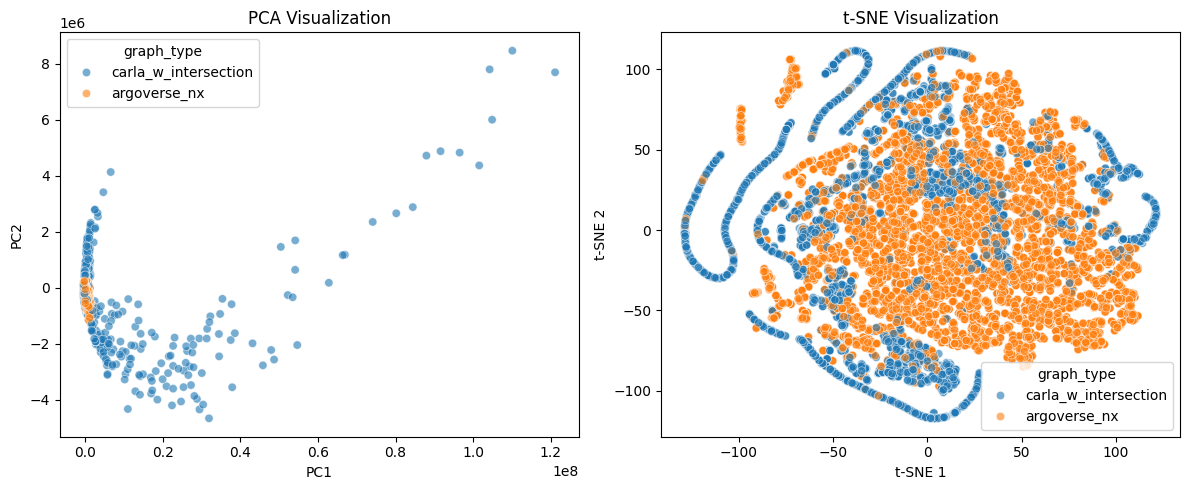

In [18]:

# Convert embeddings to numpy
embeddings_np = final_embeddings.numpy()

# PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings_np)

pca_df = pd.DataFrame(pca_result)
pca_df.columns = ["pca1", "pca2"]
pca_df["graph_type"] = graph_type
pca_df["graph_path"] = all_paths
pca_df.head()

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(x="pca1", y="pca2", alpha=0.6, hue="graph_type", legend = True, data=pca_df)
#plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.6)
plt.title('PCA Visualization')
plt.xlabel('PC1')
plt.ylabel('PC2')

# t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_result = tsne.fit_transform(embeddings_np)
tsne_df = pd.DataFrame(tsne_result)
tsne_df.columns = ["tsne1", "tsne2"]
tsne_df["graph_type"] = graph_type
tsne_df["graph_path"] = all_paths

plt.subplot(1, 2, 2)
# plt.scatter(tsne_result[:, 0], tsne_result[:, 1], alpha=0.6)
sns.scatterplot(x="tsne1", y="tsne2", alpha=0.6, hue="graph_type", legend = True, data=tsne_df)
plt.title('t-SNE Visualization')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')

plt.tight_layout()
plt.show()

In [ ]:
os.getcwd()
os.chdir("../..")
os.getcwd()

In [ ]:
pca_emb_df = pd.concat([pca_df, pd.DataFrame(embeddings_np)], axis = 1)
pca_emb_df.head(2)

In [ ]:
mask_carla = pca_df.graph_type == "carla"
mask_argo = pca_df.graph_type == "argoverse_nx"
pca_carla_df = pca_df[mask_carla].reset_index(drop=True)
pca_argo_df = pca_df[mask_argo].reset_index(drop=True)


In [ ]:
# comparing, no restrictions
for i in range(15):
    try:
        first = pca_emb_df.sample(1)
        pca_emb_df["sq_diff"] = ((pca_emb_df[list(range(256))] - first[list(range(256))].values)**2).sum(axis = 1)

        #pca_emb_df["dist"] = (pca_em.pca1 - first.pca1.iloc[0])**2 + (pca_carla_df.pca2 - first.pca2.iloc[0])**2 
        pca_emb_df.sort_values("sq_diff", inplace=True)

        if first.graph_type.iloc[0] == "carla":
            graph_1 = pca_emb_df.graph_path.iloc[0].split("/")[-1].split(".pkl")[0].split("graph_")[1]
            scn_1 = graph_1[:26]
            file_path_1 = f"/home/tmuehlen/repos/graph_coverage/actor_graphs/carla/graph_{graph_1}.pkl"
            with open(file_path_1, 'rb') as f:
                nx_graph_1 = pickle.load(f)
            g_map_1 = MapGraph()
            g_map_1.read_graph_from_file(f'/home/tmuehlen/repos/graph_coverage/carla/data/scene_{scn_1}_map_graph.pickle')
            g_map_1 = g_map_1.graph
        else:
            # argoverse option
            graph_1 = pca_emb_df.graph_path.iloc[0].split("/")[-1].split(".pkl")[0].split("graph_")[1]
            scn_1 = graph_1[:36]
            file_path_1 = f"/home/tmuehlen/repos/graph_coverage/actor_graphs/argoverse_nx/graph_{graph_1}.pkl"
            with open(file_path_1, 'rb') as f:
                nx_graph_1 = pickle.load(f)
            g_map_1 = MapGraph()
            # "/home/tmuehlen/repos/graph_coverage/data/argoversion_actor_and_map/000ace8b-a3d2-4228-bd87-91b66a9c5127_map_graph.pkl"
            g_map_1.read_graph_from_file(f'/home/tmuehlen/repos/graph_coverage/data/argoversion_actor_and_map/{scn_1}_map_graph.pkl')
            g_map_1 = g_map_1.graph.graph

        if pca_emb_df.graph_type.iloc[1] == "carla":
            graph_2 = pca_emb_df.graph_path.iloc[1].split("/")[-1].split(".pkl")[0].split("graph_")[1]
            scn_2 = graph_2[:26]
            file_path_2 = f"/home/tmuehlen/repos/graph_coverage/actor_graphs/carla/graph_{graph_2}.pkl"
            with open(file_path_2, 'rb') as f:
                nx_graph_2 = pickle.load(f)
            g_map_2 = MapGraph()
            g_map_2.read_graph_from_file(f'/home/tmuehlen/repos/graph_coverage/carla/data/scene_{scn_2}_map_graph.pickle')
            g_map_2 = g_map_2.graph
        else:
            # argoverse option
            graph_2 = pca_emb_df.graph_path.iloc[1].split("/")[-1].split(".pkl")[0].split("graph_")[1]
            scn_2 = graph_2[:36]
            file_path_2 = f"/home/tmuehlen/repos/graph_coverage/actor_graphs/argoverse_nx/graph_{graph_2}.pkl"
            with open(file_path_2, 'rb') as f:
                nx_graph_2 = pickle.load(f)
            g_map_2 = MapGraph()
            # "/home/tmuehlen/repos/graph_coverage/data/argoversion_actor_and_map/000ace8b-a3d2-4228-bd87-91b66a9c5127_map_graph.pkl"
            g_map_2.read_graph_from_file(f'/home/tmuehlen/repos/graph_coverage/data/argoversion_actor_and_map/{scn_2}_map_graph.pkl')
            g_map_2 = g_map_2.graph.graph



        # # Create figure with two subplots side by side
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
        # First scene (left subplot)
        # # First scene (left subplot)
        fig, ax1 = plot_lane_map_advanced(g_map_1, figsize=None, color_by_length=True, cmap='plasma', show_labels=False, fig = fig, ax = ax1)
        fig, ax1 = add_actors_to_map(fig, ax1, nx_graph_1, actor_size=20, show_actor_labels=False)
        fig, ax1 = add_actor_edges_to_map(fig, ax1, nx_graph_1)
        ax1.set_title(f'Scene {scn_1}')
        # # Second scene (right subplot)
        fig, ax2 = plot_lane_map_advanced(g_map_2, figsize=None, color_by_length=True, cmap='plasma', show_labels=False, fig = fig, ax = ax2)
        fig, ax2 = add_actors_to_map(fig, ax2, nx_graph_2, actor_size=20, show_actor_labels=False)
        fig, ax2 = add_actor_edges_to_map(fig, ax2, nx_graph_2)
        ax2.set_title(f'Scene {scn_2}')
        # # Adjust layout and display
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error processing scene {scn_1} and {scn_2}: {e}")


In [ ]:
# comparing argo to argo
for i in range(10):
    try:
        first = pca_argo_df.sample(1)
        pca_argo_df["dist"] = (pca_argo_df.pca1 - first.pca1.iloc[0])**2 + (pca_argo_df.pca2 - first.pca2.iloc[0])**2 
        pca_argo_df.sort_values("dist", inplace=True)
        graph_1 = pca_argo_df.graph_path.iloc[0].split("/")[-1].split(".pkl")[0].split("graph_")[1]
        graph_2 = pca_argo_df.graph_path.iloc[1].split("/")[-1].split(".pkl")[0].split("graph_")[1]
        scn_1 = graph_1[:36]
        scn_2 = graph_2[:36]
        file_path_1 = f"/home/tmuehlen/repos/graph_coverage/actor_graphs/argoverse_nx/graph_{graph_1}.pkl"
        with open(file_path_1, 'rb') as f:
            nx_graph_1 = pickle.load(f)
        file_path_2 = f"/home/tmuehlen/repos/graph_coverage/actor_graphs/argoverse_nx/graph_{graph_2}.pkl"
        with open(file_path_2, 'rb') as f:
            nx_graph_2 = pickle.load(f)
        # # Create figure with two subplots side by side
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
        # First scene (left subplot)
        g_map = MapGraph()
        # "/home/tmuehlen/repos/graph_coverage/data/argoversion_actor_and_map/000ace8b-a3d2-4228-bd87-91b66a9c5127_map_graph.pkl"
        g_map.read_graph_from_file(f'/home/tmuehlen/repos/graph_coverage/data/argoversion_actor_and_map/{scn_1}_map_graph.pkl')
        fig, ax1 = plot_lane_map_advanced(g_map.graph.graph, figsize=None, color_by_length=True, cmap='plasma', show_labels=False, fig = fig, ax = ax1)
        fig, ax1 = add_actors_to_map(fig, ax1, nx_graph_1, actor_size=20, show_actor_labels=False)
        fig, ax1 = add_actor_edges_to_map(fig, ax1, nx_graph_1)
        ax1.set_title(f'Scene {scn_1}')
        # Second scene (right subplot)
        g_map = MapGraph()
        g_map.read_graph_from_file(f'/home/tmuehlen/repos/graph_coverage/data/argoversion_actor_and_map/{scn_2}_map_graph.pkl')
        fig, ax2 = plot_lane_map_advanced(g_map.graph.graph, figsize=None, color_by_length=True, cmap='plasma', show_labels=False, fig = fig, ax = ax2)
        fig, ax2 = add_actors_to_map(fig, ax2, nx_graph_2, actor_size=20, show_actor_labels=False)
        fig, ax2 = add_actor_edges_to_map(fig, ax2, nx_graph_2)
        ax2.set_title(f'Scene {scn_2}')
        # Adjust layout and display
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error processing scene {scn_1} and {scn_2}: {e}")


In [ ]:
# comparing carla to carla
for i in range(10):
    try:
        first = pca_carla_df.sample(1)
        pca_carla_df["dist"] = (pca_carla_df.pca1 - first.pca1.iloc[0])**2 + (pca_carla_df.pca2 - first.pca2.iloc[0])**2 
        pca_carla_df.sort_values("dist", inplace=True)
        #print(pca_df.graph_path.iloc[0])
        #print(pca_df.graph_path.iloc[1])
        graph_1 = pca_carla_df.graph_path.iloc[0].split("/")[-1].split(".pkl")[0].split("graph_")[1]
        graph_2 = pca_carla_df.graph_path.iloc[1].split("/")[-1].split(".pkl")[0].split("graph_")[1]
        scn_1 = graph_1[:26]
        scn_2 = graph_2[:26]
        print(graph_1, scn_1)
        print(graph_2, scn_2)
        pca_df.head(2)
        file_path_1 = f"/home/tmuehlen/repos/graph_coverage/actor_graphs/carla/graph_{graph_1}.pkl"
        with open(file_path_1, 'rb') as f:
            nx_graph_1 = pickle.load(f)
        file_path_2 = f"/home/tmuehlen/repos/graph_coverage/actor_graphs/carla/graph_{graph_2}.pkl"
        with open(file_path_2, 'rb') as f:
            nx_graph_2 = pickle.load(f)
        # Create figure with two subplots side by side
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
        # First scene (left subplot)
        g_map = MapGraph()
        g_map.read_graph_from_file(f'/home/tmuehlen/repos/graph_coverage/carla/data/scene_{scn_1}_map_graph.pickle')
        fig, ax1 = plot_lane_map_advanced(g_map.graph, figsize=None, color_by_length=True, cmap='plasma', show_labels=False, fig = fig, ax = ax1)
        fig, ax1 = add_actors_to_map(fig, ax1, nx_graph_1, actor_size=20, show_actor_labels=False)
        fig, ax1 = add_actor_edges_to_map(fig, ax1, nx_graph_1)
        ax1.set_title(f'Scene {scn_1}')
        # Second scene (right subplot)
        g_map = MapGraph()
        g_map.read_graph_from_file(f'/home/tmuehlen/repos/graph_coverage/carla/data/scene_{scn_2}_map_graph.pickle')
        fig, ax2 = plot_lane_map_advanced(g_map.graph, figsize=None, color_by_length=True, cmap='plasma', show_labels=False, fig = fig, ax = ax2)
        fig, ax2 = add_actors_to_map(fig, ax2, nx_graph_2, actor_size=20, show_actor_labels=False)
        fig, ax2 = add_actor_edges_to_map(fig, ax2, nx_graph_2)
        ax2.set_title(f'Scene {scn_2}')
        # Adjust layout and display
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error processing scene {scn_1} and {scn_2}: {e}")


# Notebook junkyard